# GloVe Embeddings

## Load Data

In [1]:
import sys
import os

In [2]:
print(os.getcwd())
print(os.listdir("../data"))

/Users/melchiorkappel/Desktop/stat215a_final/code
['raw_text.pkl', 'subject3_ridge_streaming_80_20_k_3.pkl', '.DS_Store', 'subject2', 'glove_embeddings_preprocessed', 'subject3', 'subject2_ridge_streaming_80_20_k_3.pkl', 'wiki_giga_2024_300_MFT20_vectors_seed_2024_alpha_0.75_eta_0.05_combined.txt', 'glove_embeddings_downsampled.pkl', 'story_glove_embeddings.pkl']


In [3]:
import pickle

raw_text_path = "../data/raw_text.pkl"   # absolute path
with open(raw_text_path, "rb") as f:
    raw_text = pickle.load(f)

print("Loaded:", type(raw_text), len(raw_text))

Loaded: <class 'dict'> 109


/var/folders/c5/41k2y0bj2d1bcw8hyvm28y040000gn/T/ipykernel_50096/2662573124.py:5: DeprecationWarning: numpy.core.numeric is deprecated and has been renamed to numpy._core.numeric. The numpy._core namespace contains private NumPy internals and its use is discouraged, as NumPy internals can change without warning in any release. In practice, most real-world usage of numpy.core is to access functionality in the public NumPy API. If that is the case, use the public NumPy API. If not, you are using NumPy internals. If you would still like to access an internal attribute, use numpy._core.numeric._frombuffer.
  raw_text = pickle.load(f)


In [4]:
import pickle
import numpy as np

RAW_TEXT_PATH = "../data/raw_text.pkl"

with open(RAW_TEXT_PATH, 'rb') as f:
    raw_text = pickle.load(f)

print("Number of stories:", len(raw_text))
print("Story names (first 10):", list(raw_text.keys())[:10])

# Inspect one story
print("raw_text keys():", list(raw_text.keys())[:])
story_name = list(raw_text.keys())[0]
ds = raw_text[story_name]

print("\nExample story:", story_name)
print("type(ds):", type(ds))
print("len(ds.data):", len(ds.data))
print("data_times shape:", ds.data_times.shape)
print("len(split_inds):", len(ds.split_inds))
print("tr_times shape:", ds.tr_times.shape)

print("\nFirst 30 tokens:")
print(ds.data[:30])

Number of stories: 109
Story names (first 10): ['sweetaspie', 'thatthingonmyarm', 'tildeath', 'indianapolis', 'lawsthatchokecreativity', 'golfclubbing', 'jugglingandjesus', 'shoppinginchina', 'cocoonoflove', 'hangtime']
raw_text keys(): ['sweetaspie', 'thatthingonmyarm', 'tildeath', 'indianapolis', 'lawsthatchokecreativity', 'golfclubbing', 'jugglingandjesus', 'shoppinginchina', 'cocoonoflove', 'hangtime', 'beneaththemushroomcloud', 'dialogue4', 'thepostmanalwayscalls', 'stumblinginthedark', 'kiksuya', 'haveyoumethimyet', 'theinterview', 'againstthewind', 'tetris', 'canplanetearthfeedtenbillionpeoplepart2', 'alternateithicatom', 'goldiethegoldfish', 'seedpotatoesofleningrad', 'onapproachtopluto', 'canplanetearthfeedtenbillionpeoplepart1', 'bluehope', 'superheroesjustforeachother', 'howtodraw', 'myfirstdaywiththeyankees', 'thumbsup', 'avatar', 'mayorofthefreaks', 'gangstersandcookies', 'breakingupintheageofgoogle', 'forgettingfear', 'waitingtogo', 'firetestforlove', 'goingthelibertyway'

/var/folders/c5/41k2y0bj2d1bcw8hyvm28y040000gn/T/ipykernel_50096/1497159947.py:7: DeprecationWarning: numpy.core.numeric is deprecated and has been renamed to numpy._core.numeric. The numpy._core namespace contains private NumPy internals and its use is discouraged, as NumPy internals can change without warning in any release. In practice, most real-world usage of numpy.core is to access functionality in the public NumPy API. If that is the case, use the public NumPy API. If not, you are using NumPy internals. If you would still like to access an internal attribute, use numpy._core.numeric._frombuffer.
  raw_text = pickle.load(f)


In [5]:
def load_glove_embeddings(glove_path):
    """
    Load GloVe embeddings from a .txt file.

    Args:
        glove_path: Path to GloVe text file 

    Returns:
        word_to_vec: dict mapping word -> np.ndarray (embedding vector).
        embedding_dim: int, dimensionality of the embeddings.
    """
    word_to_vec = {}
    embedding_dim = None

    with open(glove_path, "r", encoding="utf-8") as f:
        for line in f:
            parts = line.rstrip().split(" ")
            if len(parts) < 10:
                # Skip weird / malformed lines
                continue
            word = parts[0]
            vec = np.asarray(parts[1:], dtype=np.float32)
            if embedding_dim is None:
                embedding_dim = vec.shape[0]
            word_to_vec[word] = vec

    if embedding_dim is None:
        raise ValueError("Could not infer embedding dimension from GloVe file.")

    print(f"Loaded {len(word_to_vec):,} GloVe vectors with dim = {embedding_dim}")
    return word_to_vec, embedding_dim

In [6]:
GLOVE_PATH = "../data/wiki_giga_2024_300_MFT20_vectors_seed_2024_alpha_0.75_eta_0.05_combined.txt" 
glove_dict, glove_dim = load_glove_embeddings(GLOVE_PATH)

Loaded 1,291,147 GloVe vectors with dim = 300


In [7]:
import string

def normalize_token(token):
    """
    Normalize a token for GloVe lookup:
    - lowercase
    - strip leading/trailing punctuation
    """
    token = token.lower()
    token = token.strip(string.punctuation)
    return token

def embed_tokens_with_glove(tokens, glove_dict, embedding_dim, oov_strategy="zeros", rng=None):
    """
    Turn a list of tokens into a (T, embedding_dim) matrix using GloVe.

    Args:
        tokens: list of str
        glove_dict: dict word -> np.ndarray
        embedding_dim: int
        oov_strategy: 'zeros', 'random', or 'skip'
        rng: np.random.Generator for 'random' strategy

    Returns:
        embeddings: np.ndarray of shape (T, embedding_dim) if not skipping words,
                    or (T_effective, embedding_dim) if 'skip'.
    """
    if oov_strategy == "random" and rng is None:
        rng = np.random.default_rng(215)  # fixed seed for reproducibility

    vectors = []
    for tok in tokens:
        norm_tok = normalize_token(tok)
        if norm_tok in glove_dict:
            vec = glove_dict[norm_tok]
            vectors.append(vec)
        else:
            if oov_strategy == "zeros":
                vectors.append(np.zeros(embedding_dim, dtype=np.float32))
            elif oov_strategy == "random":
                vec = rng.normal(loc=0.0, scale=0.1, size=(embedding_dim,)).astype(np.float32)
                vectors.append(vec)
            elif oov_strategy == "skip":
                # just don't append anything
                continue
            else:
                raise ValueError(f"Unknown oov_strategy: {oov_strategy}")

    if len(vectors) == 0:
        # safety: if we somehow skipped everything, return empty array
        return np.zeros((0, embedding_dim), dtype=np.float32)

    return np.stack(vectors, axis=0)

In [8]:
def build_glove_story_embeddings(raw_text, glove_dict, embedding_dim, oov_strategy="zeros"):
    """
    Build GloVe embeddings for every story in raw_text.

    Args:
        raw_text: dict story_name -> list of tokens
        glove_dict: dict word -> GloVe vector
        embedding_dim: int
        oov_strategy: 'zeros', 'random', or 'skip'

    Returns:
        story_embeddings: dict story_name -> np.ndarray (T_tokens, embedding_dim)
    """
    story_embeddings = {}
    for story_name, ds in raw_text.items():
        tokens = ds.data
        words = ds.data               # list[str]
        word_times = ds.data_times    # np.array, shape (T,)
        tr_times = ds.tr_times        # np.array, shape (n_TR,)
        # remove empty tokens
        #tokens = [t for t in tokens if t != ""]
        
        # Many sequences start with an empty token, feel free to drop them:
        #tokens = [t for t in tokens if t != ""]
        emb = embed_tokens_with_glove(tokens, glove_dict, embedding_dim, oov_strategy=oov_strategy)
        story_embeddings[story_name] = {
            "words": words,
            "word_times": word_times,
            "tr_times": tr_times,
            "embeddings": emb,
        }
        
    #. print a table of the number of tokens and embedding shapes for each story    
    for story_name, data in story_embeddings.items():
        print(f"{story_name}: words={len(data['words'])}, emb.shape={data['embeddings'].shape}")
    return story_embeddings

## Create embeddings

In [9]:
raw_text_path = "../data/raw_text.pkl"

with open(raw_text_path, "rb") as f:
    raw_text = pickle.load(f)

#glove_dict, glove_dim = load_glove_embeddings(glove_path)
story_embeddings = build_glove_story_embeddings(raw_text, glove_dict, glove_dim)

/var/folders/c5/41k2y0bj2d1bcw8hyvm28y040000gn/T/ipykernel_50096/2137974708.py:4: DeprecationWarning: numpy.core.numeric is deprecated and has been renamed to numpy._core.numeric. The numpy._core namespace contains private NumPy internals and its use is discouraged, as NumPy internals can change without warning in any release. In practice, most real-world usage of numpy.core is to access functionality in the public NumPy API. If that is the case, use the public NumPy API. If not, you are using NumPy internals. If you would still like to access an internal attribute, use numpy._core.numeric._frombuffer.
  raw_text = pickle.load(f)


sweetaspie: words=697, emb.shape=(697, 300)
thatthingonmyarm: words=2073, emb.shape=(2073, 300)
tildeath: words=2297, emb.shape=(2297, 300)
indianapolis: words=1554, emb.shape=(1554, 300)
lawsthatchokecreativity: words=2084, emb.shape=(2084, 300)
golfclubbing: words=1211, emb.shape=(1211, 300)
jugglingandjesus: words=887, emb.shape=(887, 300)
shoppinginchina: words=1731, emb.shape=(1731, 300)
cocoonoflove: words=1984, emb.shape=(1984, 300)
hangtime: words=1927, emb.shape=(1927, 300)
beneaththemushroomcloud: words=1916, emb.shape=(1916, 300)
dialogue4: words=1692, emb.shape=(1692, 300)
thepostmanalwayscalls: words=2220, emb.shape=(2220, 300)
stumblinginthedark: words=2681, emb.shape=(2681, 300)
kiksuya: words=1699, emb.shape=(1699, 300)
haveyoumethimyet: words=2985, emb.shape=(2985, 300)
theinterview: words=1079, emb.shape=(1079, 300)
againstthewind: words=838, emb.shape=(838, 300)
tetris: words=1350, emb.shape=(1350, 300)
canplanetearthfeedtenbillionpeoplepart2: words=2532, emb.shape=(

## Save embeddings

In [10]:
# save the embeddings for later use
out_path = "../data/story_glove_embeddings.pkl"
with open(out_path, "wb") as f:
    pickle.dump(story_embeddings, f)    

In [11]:
# check embeddings
with open(out_path, "rb") as f:
    bert_emb = pickle.load(f)

print(type(bert_emb))
print(list(bert_emb.keys())[:5])
story_ids = list(bert_emb.keys())
second_id = story_ids[0]
second_id
item = bert_emb[second_id]

words = item["words"]              # list[str]
word_times = item["word_times"]    # numpy array, shape (T,)
embeddings = item["embeddings"]    # numpy array, shape (T, 768)
tr_times = item["tr_times"]        # numpy array, shape (n_TR,)

# print tr_times
print("tr_times shape:", tr_times.shape)
print(tr_times)

for i in range(5):
    print(f"{i:02d}  word = {words[i]!r}")
    print("embedding[:10] =", embeddings[i][:10])
    print()


<class 'dict'>
['sweetaspie', 'thatthingonmyarm', 'tildeath', 'indianapolis', 'lawsthatchokecreativity']
tr_times shape: (172,)
[ -9.  -7.  -5.  -3.  -1.   1.   3.   5.   7.   9.  11.  13.  15.  17.
  19.  21.  23.  25.  27.  29.  31.  33.  35.  37.  39.  41.  43.  45.
  47.  49.  51.  53.  55.  57.  59.  61.  63.  65.  67.  69.  71.  73.
  75.  77.  79.  81.  83.  85.  87.  89.  91.  93.  95.  97.  99. 101.
 103. 105. 107. 109. 111. 113. 115. 117. 119. 121. 123. 125. 127. 129.
 131. 133. 135. 137. 139. 141. 143. 145. 147. 149. 151. 153. 155. 157.
 159. 161. 163. 165. 167. 169. 171. 173. 175. 177. 179. 181. 183. 185.
 187. 189. 191. 193. 195. 197. 199. 201. 203. 205. 207. 209. 211. 213.
 215. 217. 219. 221. 223. 225. 227. 229. 231. 233. 235. 237. 239. 241.
 243. 245. 247. 249. 251. 253. 255. 257. 259. 261. 263. 265. 267. 269.
 271. 273. 275. 277. 279. 281. 283. 285. 287. 289. 291. 293. 295. 297.
 299. 301. 303. 305. 307. 309. 311. 313. 315. 317. 319. 321. 323. 325.
 327. 329. 331. 333.

# Proprocessing

In [12]:
from preprocessing import *
from pathlib import Path

In [13]:
from preprocessing import downsample_word_vectors, make_delayed

TEXT_PATH = "../data/raw_text.pkl"
GLOVE_EMB_PATH = "../data/story_glove_embeddings.pkl"
# DataSequence (wordseqs)
with open(TEXT_PATH, "rb") as f:
    wordseqs = pickle.load(f)   # dict: story_id -> DataSequence

print("wordseqs stories:", list(wordseqs.keys())[:5])

# GloVe embedding
with open(GLOVE_EMB_PATH, "rb") as f:
    glove_emb = pickle.load(f)   # dict: story_id -> {..., "embeddings": (T,768)}

print("glove_emb stories:", list(glove_emb.keys())[:5])

# check story id
stories = sorted(set(wordseqs.keys()) & set(glove_emb.keys()))
print("num stories:", len(stories))
stories[:5]

wordseqs stories: ['sweetaspie', 'thatthingonmyarm', 'tildeath', 'indianapolis', 'lawsthatchokecreativity']
glove_emb stories: ['sweetaspie', 'thatthingonmyarm', 'tildeath', 'indianapolis', 'lawsthatchokecreativity']
num stories: 109


/var/folders/c5/41k2y0bj2d1bcw8hyvm28y040000gn/T/ipykernel_50096/3287810267.py:7: DeprecationWarning: numpy.core.numeric is deprecated and has been renamed to numpy._core.numeric. The numpy._core namespace contains private NumPy internals and its use is discouraged, as NumPy internals can change without warning in any release. In practice, most real-world usage of numpy.core is to access functionality in the public NumPy API. If that is the case, use the public NumPy API. If not, you are using NumPy internals. If you would still like to access an internal attribute, use numpy._core.numeric._frombuffer.
  wordseqs = pickle.load(f)   # dict: story_id -> DataSequence


['adollshouse',
 'adventuresinsayingyes',
 'afatherscover',
 'afearstrippedbare',
 'againstthewind']

In [14]:
# from ridge_utils.DataSequence import DataSequence

# # Trim the first 10 TRs and last 5 TRs from downsampled semantic sequences
# trimmed_semanticseqs = {}

# for sid in stories:
#     ds = wordseqs[sid]
#     # ds.data has shape (num_TRs, embedding_dim)
#     # Trim first 10 and last 5 TRs
#     trimmed_data = ds.data[10:-5]
    
#     # Create a new DataSequence object with trimmed data
#     trimmed_ds = DataSequence(
#         data=trimmed_data,
#         tr_times=ds.tr_times[10:-5],
#         data_times=None,  # Not applicable for downsampled data
#         split_inds=ds.split_inds if hasattr(ds, 'split_inds') else []
#     )
#     trimmed_semanticseqs[sid] = trimmed_ds

# print(f"Trimmed {len(trimmed_semanticseqs)} stories")
# print(f"Example: {stories[0]}")
# print(f"  Original:: {wordseqs[stories[0]].data}")
# print(f"  Original length:: {len(wordseqs[stories[0]].data)}")
# print(f"  Trimmed: {trimmed_semanticseqs[stories[0]].data}")
# print(f"  Trimmed length:: {len(trimmed_semanticseqs[stories[0]].data)}")


## Downsample

In [15]:
word_vectors = {}
for sid in stories:
    embs = glove_emb[sid]["embeddings"]   # (num_words, 768)
    word_vectors[sid] = embs.astype("float32")

print("word_vector[story_id] shape:", word_vectors[stories[0]].shape)
print("wordseqs[story_id] shape:", len(wordseqs[stories[0]].data))

downsampled_semanticseqs = downsample_word_vectors(
    stories=stories,
    word_vectors=word_vectors,
    wordseqs=wordseqs
)

print("downsampled_semanticseqs stories:", list(downsampled_semanticseqs.keys())[:5])
print("downsampled_semanticseqs[story_id] shape:", downsampled_semanticseqs[stories[0]].data.shape)

word_vector[story_id] shape: (1656, 300)
wordseqs[story_id] shape: 1656
downsampled_semanticseqs stories: ['adollshouse', 'adventuresinsayingyes', 'afatherscover', 'afearstrippedbare', 'againstthewind']
downsampled_semanticseqs[story_id] shape: (256, 300)


In [16]:
# save preprocessed data
OUT_DIR = Path("../data")
OUT_DIR.mkdir(parents=True, exist_ok=True)
out_path = OUT_DIR / "glove_embeddings_downsampled.pkl"
with open(out_path, "wb") as f:
    pickle.dump(downsampled_semanticseqs, f)

In [17]:
# open and check
with open(out_path, "rb") as f:
    loaded_data = pickle.load(f)
print("loaded_data stories:", list(loaded_data.keys())[:5])
print("loaded_data[story_id] shape:", loaded_data[stories[0]].data.shape)

loaded_data stories: ['adollshouse', 'adventuresinsayingyes', 'afatherscover', 'afearstrippedbare', 'againstthewind']
loaded_data[story_id] shape: (256, 300)


## Trim and delay

In [18]:
print(stories)

['adollshouse', 'adventuresinsayingyes', 'afatherscover', 'afearstrippedbare', 'againstthewind', 'alternateithicatom', 'avatar', 'backsideofthestorm', 'becomingindian', 'beneaththemushroomcloud', 'birthofanation', 'bluehope', 'breakingupintheageofgoogle', 'buck', 'canadageeseandddp', 'canplanetearthfeedtenbillionpeoplepart1', 'canplanetearthfeedtenbillionpeoplepart2', 'canplanetearthfeedtenbillionpeoplepart3', 'catfishingstrangerstofindmyself', 'cautioneating', 'christmas1940', 'cocoonoflove', 'comingofageondeathrow', 'dialogue1', 'dialogue2', 'dialogue3', 'dialogue4', 'dialogue5', 'dialogue6', 'escapingfromadirediagnosis', 'exorcism', 'eyespy', 'findingmyownrescuer', 'firetestforlove', 'food', 'forgettingfear', 'fromboyhoodtofatherhood', 'gangstersandcookies', 'goingthelibertyway', 'goldiethegoldfish', 'golfclubbing', 'googlingstrangersandkentuckybluegrass', 'gpsformylostidentity', 'hangtime', 'haveyoumethimyet', 'howtodraw', 'ifthishaircouldtalk', 'igrewupinthewestborobaptistchurch',

In [19]:
#OUT_DIR = Path("/ocean/projects/mth250011p/ypan14/preprocessing")
OUT_DIR = Path("../data/glove_embeddings_preprocessed")
OUT_DIR.mkdir(parents=True, exist_ok=True)

BOLD_BASE = Path("../data")
SUBJECT_DIRS = {
    2: BOLD_BASE / "subject2",
    3: BOLD_BASE / "subject3",
}

def preprocess_subject_streaming(subject_id, delays=None):
    subj_dir = SUBJECT_DIRS[subject_id]
    assert subj_dir.is_dir(), f"{subj_dir} does not exist"

    missing_stories = []

    for sid in stories:
        ds = wordseqs[sid]
        tr_times = ds.tr_times
        stim_tr  = downsampled_semanticseqs[sid]

        assert stim_tr.shape[0] == len(tr_times)

        bold_path = subj_dir / f"{sid}.npy"
        if not bold_path.is_file():
            print(f"[WARN] Subject {subject_id}: missing BOLD for story '{sid}', skipping.")
            missing_stories.append(sid)
            continue

        try:
            bold = np.load(bold_path)
        except Exception as e:
            print(f"[WARN] Subject {subject_id}, story {sid}: failed to load BOLD data. Error: {e}")
            missing_stories.append(sid)
            continue

        n_stim = stim_tr.shape[0]
        n_bold = bold.shape[0]

        if n_stim < n_bold:
            print(f"[WARN] {sid}: stim shorter than bold, skipping.")
            missing_stories.append(sid)
            continue

        trim_start = 10
        trim_end   = 5

        # check length
        if n_stim - trim_start - trim_end < n_bold:
            print(f"[WARN] {sid}: stim too short after fixed trimming, skipping.")
            missing_stories.append(sid)
            continue

        stim_trim = stim_tr[trim_start : n_stim - trim_end]

        # after trimming, must match bold length
        if stim_trim.shape[0] != n_bold:
            print(
                f"[WARN] {sid}: mismatch after fixed trim "
                f"(stim={stim_trim.shape[0]}, bold={n_bold}), skipping."
            )
            missing_stories.append(sid)
            continue

        if stim_trim.shape[0] != n_bold:
            print(f"[WARN] {sid}: mismatch after trim, skipping.")
            missing_stories.append(sid)
            continue

        # delay
        if delays is None:
            raise ValueError("delays must be provided if only X_delayed is saved.")

        X_delayed = make_delayed(stim_trim, delays=delays)
        X_delayed = X_delayed.astype("float32")

        bold = bold.astype("float32")

        result = {
            "X_delayed": X_delayed,   # (N, 768 * len(delays))
            "bold": bold,             # (N, n_vox)
        }

        out_file = OUT_DIR / f"subject{subject_id}_{sid}_Xdelayed.pkl"
        with open(out_file, "wb") as f:
            pickle.dump(result, f)
            print(f"Estimated size in MB = {(X_delayed.nbytes + bold.nbytes) / (1024 * 1024):.2f}")

        print(
            f"[SAVE] Subject {subject_id}, story {sid}: "
            f"X_delayed {X_delayed.shape}, bold {bold.shape}, saved"
        )

        del bold, stim_trim, X_delayed, result

    if missing_stories:
        print(f"\n[INFO] Subject {subject_id} skipped stories:")
        for s in missing_stories:
            print("  -", s)
    else:
        print(f"\n[INFO] Subject {subject_id}: all stories processed.")
        
    # print saved stories and order them alphabetically
    saved_files = list(OUT_DIR.glob(f"subject{subject_id}_*_Xdelayed.pkl"))
    saved_stories = sorted([f.stem.split("_")[1] for f in saved_files])
    print(f"[INFO] Subject {subject_id}: saved stories:")
    for s in saved_stories:
        print("  -", s)

# def preprocess_subject_streaming(subject_id, delays=None):
#     subj_dir = SUBJECT_DIRS[subject_id]
#     assert subj_dir.is_dir(), f"{subj_dir} does not exist"

#     missing_stories = []

#     for sid in stories:
#         ds = wordseqs[sid]
#         tr_times = ds.tr_times
#         stim_tr  = downsampled_semanticseqs[sid]

#         assert stim_tr.shape[0] == len(tr_times)

#         bold_path = subj_dir / f"{sid}.npy"
#         if not bold_path.is_file():
#             print(f"[WARN] Subject {subject_id}: missing BOLD for story '{sid}', skipping.")
#             missing_stories.append(sid)
#             continue
        
#         try:
#             bold = np.load(bold_path)
#         except Exception as e:
#             print(f"[WARN] Subject {subject_id}, story {sid}: failed to load BOLD data. Error: {e}")
#             missing_stories.append(sid)
#             continue

#         n_stim = stim_tr.shape[0]
#         n_bold = bold.shape[0]

#         if n_stim < n_bold:
#             print(f"[WARN] {sid}: stim shorter than bold, skipping.")
#             missing_stories.append(sid)
#             continue

#         # TR trimming to match BOLD length
#         diff = n_stim - n_bold
#         drop_start = diff // 3 if diff > 0 else 0
#         drop_end = diff - drop_start if diff > 0 else 0

#         stim_trim = stim_tr[drop_start : n_stim - drop_end]

#         if stim_trim.shape[0] != n_bold:
#             print(f"[WARN] {sid}: mismatch after trim, skipping.")
#             missing_stories.append(sid)
#             continue

#         # delay
#         if delays is None:
#             raise ValueError("delays must be provided if only X_delayed is saved.")

#         X_delayed = make_delayed(stim_trim, delays=delays)
#         X_delayed = X_delayed.astype("float32")

#         bold = bold.astype("float32")

#         result = {
#             "X_delayed": X_delayed,   # (N, 768 * len(delays))
#             "bold": bold,             # (N, n_vox)
#         }

#         out_file = OUT_DIR / f"subject{subject_id}_{sid}_Xdelayed.pkl"
#         with open(out_file, "wb") as f:
#             pickle.dump(result, f)

#         print(
#             f"[SAVE] Subject {subject_id}, story {sid}: "
#             f"X_delayed {X_delayed.shape}, bold {bold.shape}, saved"
#         )

#         del bold, stim_trim, X_delayed, result

#     if missing_stories:
#         print(f"\n[INFO] Subject {subject_id} skipped stories:")
#         for s in missing_stories:
#             print("  -", s)
#     else:
#         print(f"\n[INFO] Subject {subject_id}: all stories processed.")
        
#     # print saved stories and order them alphabetically
#     saved_files = list(OUT_DIR.glob(f"subject{subject_id}_*_Xdelayed.pkl"))
#     saved_stories = sorted([f.stem.split("_")[1] for f in saved_files])
#     print(f"[INFO] Subject {subject_id}: saved stories:")
#     for s in saved_stories:
#         print("  -", s)
 

In [20]:
delays = [1,2,3,4]
preprocess_subject_streaming(2, delays=delays)


[WARN] Subject 2: missing BOLD for story 'adollshouse', skipping.
[WARN] Subject 2: missing BOLD for story 'adventuresinsayingyes', skipping.
[WARN] Subject 2: missing BOLD for story 'afatherscover', skipping.
[WARN] Subject 2: missing BOLD for story 'afearstrippedbare', skipping.
[WARN] Subject 2: missing BOLD for story 'againstthewind', skipping.
[WARN] Subject 2: missing BOLD for story 'alternateithicatom', skipping.
Estimated size in MB = 133.63
[SAVE] Subject 2, story avatar: X_delayed (367, 1200), bold (367, 94251), saved
[WARN] Subject 2: missing BOLD for story 'backsideofthestorm', skipping.
[WARN] Subject 2: missing BOLD for story 'becomingindian', skipping.
[WARN] Subject 2: missing BOLD for story 'beneaththemushroomcloud', skipping.
[WARN] Subject 2: missing BOLD for story 'birthofanation', skipping.
Estimated size in MB = 148.92
[SAVE] Subject 2, story bluehope: X_delayed (409, 1200), bold (409, 94251), saved
[WARN] Subject 2: missing BOLD for story 'breakingupintheageofgoo

In [21]:
preprocess_subject_streaming(3, delays=delays)

[WARN] Subject 3: missing BOLD for story 'adollshouse', skipping.
[WARN] Subject 3: missing BOLD for story 'adventuresinsayingyes', skipping.
[WARN] Subject 3: missing BOLD for story 'afatherscover', skipping.
[WARN] Subject 3: missing BOLD for story 'afearstrippedbare', skipping.
[WARN] Subject 3: missing BOLD for story 'againstthewind', skipping.
[WARN] Subject 3: missing BOLD for story 'alternateithicatom', skipping.
Estimated size in MB = 135.46
[SAVE] Subject 3, story avatar: X_delayed (367, 1200), bold (367, 95556), saved
[WARN] Subject 3: missing BOLD for story 'backsideofthestorm', skipping.
[WARN] Subject 3: missing BOLD for story 'becomingindian', skipping.
[WARN] Subject 3: missing BOLD for story 'beneaththemushroomcloud', skipping.
[WARN] Subject 3: missing BOLD for story 'birthofanation', skipping.
Estimated size in MB = 150.96
[SAVE] Subject 3, story bluehope: X_delayed (409, 1200), bold (409, 95556), saved
[WARN] Subject 3: missing BOLD for story 'breakingupintheageofgoo

In [22]:
# load and check the bluehope story for subject 2
subject_id = 2
sid = stories[6]
file_path = OUT_DIR / f"subject{subject_id}_{sid}_Xdelayed.pkl"
with open(file_path, "rb") as f:
    data = pickle.load(f)
    
print(data.keys())
X_delayed = data["X_delayed"]
bold = data["bold"]
print("X_delayed shape:", X_delayed.shape)
print("bold shape:", bold.shape)    


dict_keys(['X_delayed', 'bold'])
X_delayed shape: (367, 1200)
bold shape: (367, 94251)


In [23]:
# Load the ridge streaming results file
ridge_results_path = "../data/subject2_ridge_streaming_80_20_k_3.pkl"
with open(ridge_results_path, "rb") as f:
    ridge_results = pickle.load(f)

print("Type:", type(ridge_results))
print("\nKeys:", list(ridge_results.keys()) if isinstance(ridge_results, dict) else "Not a dict")

# Explore the contents
if isinstance(ridge_results, dict):
    print(f"\nNumber of entries: {len(ridge_results)}")
    
    # Show first few keys
    keys_list = list(ridge_results.keys())
    print(f"\nFirst 10 keys: {keys_list[:10]}")
    
    # Inspect one entry in detail
    if len(keys_list) > 0:
        sample_key = keys_list[0]
        sample_value = ridge_results[sample_key]
        print(f"\nSample entry for key '{sample_key}':")
        print(f"  Type: {type(sample_value)}")
        
        if isinstance(sample_value, dict):
            print(f"  Keys: {list(sample_value.keys())}")
            for k, v in sample_value.items():
                if isinstance(v, np.ndarray):
                    print(f"    {k}: shape={v.shape}, dtype={v.dtype}")
                else:
                    print(f"    {k}: {type(v)}")
        elif isinstance(sample_value, np.ndarray):
            print(f"  Shape: {sample_value.shape}, dtype: {sample_value.dtype}")
        else:
            print(f"  Value: {sample_value}")
else:
    print("\nContent:", ridge_results)

Type: <class 'dict'>

Keys: ['W', 'best_alpha', 'alphas', 'cv_results', 'metrics', 'mean_X', 'std_X', 'mean_Y', 'std_Y', 'train_files', 'test_files']

Number of entries: 11

First 10 keys: ['W', 'best_alpha', 'alphas', 'cv_results', 'metrics', 'mean_X', 'std_X', 'mean_Y', 'std_Y', 'train_files']

Sample entry for key 'W':
  Type: <class 'numpy.ndarray'>
  Shape: (1200, 94251), dtype: float32


In [24]:
# list all values for the keys in ridge_results
for key, value in ridge_results.items():
    print(f"Key: {key}, Value Type: {type(value)}")
    # print the shape if it's a numpy array
    if isinstance(value, np.ndarray):
        print(f"  Shape: {value.shape}")

Key: W, Value Type: <class 'numpy.ndarray'>
  Shape: (1200, 94251)
Key: best_alpha, Value Type: <class 'float'>
Key: alphas, Value Type: <class 'list'>
Key: cv_results, Value Type: <class 'dict'>
Key: metrics, Value Type: <class 'dict'>
Key: mean_X, Value Type: <class 'numpy.ndarray'>
  Shape: (1200,)
Key: std_X, Value Type: <class 'numpy.ndarray'>
  Shape: (1200,)
Key: mean_Y, Value Type: <class 'numpy.ndarray'>
  Shape: (94251,)
Key: std_Y, Value Type: <class 'numpy.ndarray'>
  Shape: (94251,)
Key: train_files, Value Type: <class 'list'>
Key: test_files, Value Type: <class 'list'>


In [25]:
import pandas as pd

# Prepare the data for the table
table_data = [
    ("story_ids", type(story_ids).__name__, len(story_ids)),
    ("story_name", type(story_name).__name__, story_name),
    ("subject_id", type(subject_id).__name__, subject_id),
    ("tr_times", type(tr_times).__name__, tr_times.shape),
    ("word_times", type(word_times).__name__, word_times.shape),
    ("word_vectors", type(word_vectors).__name__, f"{len(word_vectors)} stories"),
    ("words", type(words).__name__, len(words)),
    ("wordseqs", type(wordseqs).__name__, f"{len(wordseqs)} stories"),
]

df_table = pd.DataFrame(table_data, columns=["Key", "Type", "Value"])
print(df_table)

            Key     Type        Value
0     story_ids     list          109
1    story_name      str   sweetaspie
2    subject_id      int            2
3      tr_times  ndarray       (172,)
4    word_times  ndarray       (697,)
5  word_vectors     dict  109 stories
6         words     list          697
7      wordseqs     dict  109 stories


In [26]:
import pandas as pd

# Prepare a summary DataFrame with stories as rows and keys as columns
summary_rows = []
for sid in story_ids:
    row = {
        "story_id": sid,
        "num_words": len(word_vectors[sid]),
        "wordseq_type": type(wordseqs[sid]).__name__,
        "word_times_len": len(wordseqs[sid].word_times) if hasattr(wordseqs[sid], "word_times") else None,
        "tr_times_len": len(wordseqs[sid].tr_times) if hasattr(wordseqs[sid], "tr_times") else None,
    }
    summary_rows.append(row)

df_summary = pd.DataFrame(summary_rows)
print(df_summary.head())

                  story_id  num_words  wordseq_type word_times_len  \
0               sweetaspie        697  DataSequence           None   
1         thatthingonmyarm       2073  DataSequence           None   
2                 tildeath       2297  DataSequence           None   
3             indianapolis       1554  DataSequence           None   
4  lawsthatchokecreativity       2084  DataSequence           None   

   tr_times_len  
0           172  
1           449  
2           338  
3           317  
4           449  


In [27]:
# print a table for 'W', 'best_alpha', 'alphas', 'cv_results', 'metrics', 'mean_X', 'std_X', 'mean_Y', 'std_Y', 'train_files', 'test_files'
data_keys = [
    'W', 'best_alpha', 'alphas', 'cv_results', 'metrics',
    'mean_X', 'std_X', 'mean_Y', 'std_Y', 'train_files', 'test_files'
]
summary_data = []
for key in data_keys:
    if key in ridge_results:
        value = ridge_results[key]
        if isinstance(value, np.ndarray):
            summary_data.append((key, type(value).__name__, value.shape))
        else:
            summary_data.append((key, type(value).__name__, str(value)))
    else:
        summary_data.append((key, "N/A", "N/A"))
        
df_ridge_summary = pd.DataFrame(summary_data)

## Plot

/opt/miniconda3/envs/215a/lib/python3.13/site-packages/sklearn/utils/extmath.py:350: RuntimeWarning: divide by zero encountered in matmul
  Q, _ = normalizer(A @ Q)
/opt/miniconda3/envs/215a/lib/python3.13/site-packages/sklearn/utils/extmath.py:350: RuntimeWarning: overflow encountered in matmul
  Q, _ = normalizer(A @ Q)
/opt/miniconda3/envs/215a/lib/python3.13/site-packages/sklearn/utils/extmath.py:350: RuntimeWarning: invalid value encountered in matmul
  Q, _ = normalizer(A @ Q)
/opt/miniconda3/envs/215a/lib/python3.13/site-packages/sklearn/utils/extmath.py:351: RuntimeWarning: divide by zero encountered in matmul
  Q, _ = normalizer(A.T @ Q)
/opt/miniconda3/envs/215a/lib/python3.13/site-packages/sklearn/utils/extmath.py:351: RuntimeWarning: overflow encountered in matmul
  Q, _ = normalizer(A.T @ Q)
/opt/miniconda3/envs/215a/lib/python3.13/site-packages/sklearn/utils/extmath.py:351: RuntimeWarning: invalid value encountered in matmul
  Q, _ = normalizer(A.T @ Q)
/opt/miniconda3/en

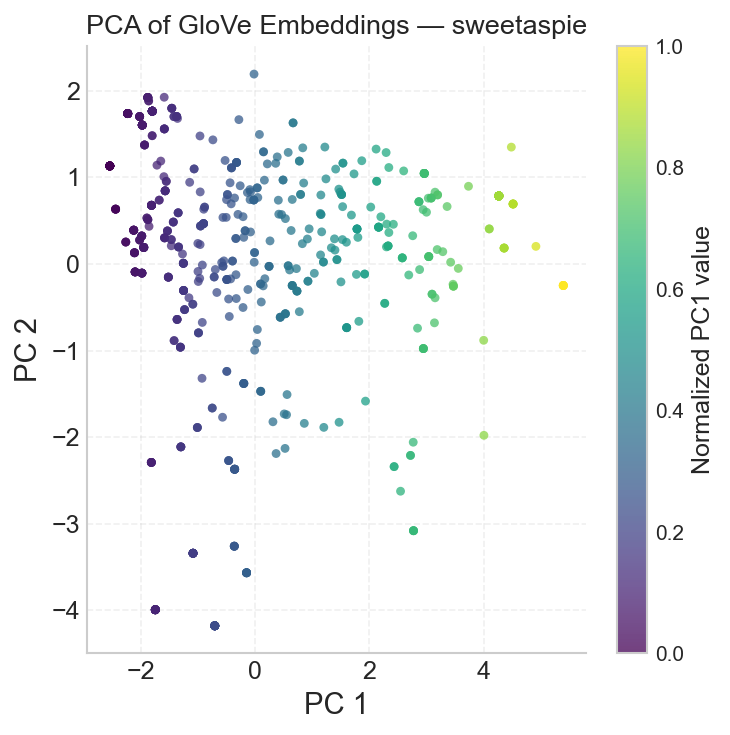

In [28]:
# PCA and visualization
import matplotlib.pyplot as plt
from sklearn.decomposition import PCA

pca = PCA(n_components=2)
X2 = pca.fit_transform(embeddings)

norm = (X2[:,0] - X2[:,0].min()) / (X2[:,0].max() - X2[:,0].min())

plt.figure(figsize=(5,5), dpi=150)
plt.style.use("seaborn-v0_8-whitegrid")

# Scatter plot with transparency + colormap
plt.scatter(
    X2[:,0], X2[:,1],
    c=norm, cmap="viridis",     
    s=18,                      
    alpha=0.75,                
    edgecolor="none"
)

plt.title(f"PCA of GloVe Embeddings — {second_id}", fontsize=13)
plt.xlabel("PC 1", fontsize=14)
plt.ylabel("PC 2", fontsize=14)

plt.xticks(fontsize=12)
plt.yticks(fontsize=12)

plt.grid(True, linestyle="--", alpha=0.3)

for spine in ["top", "right"]:
    plt.gca().spines[spine].set_visible(False)

cbar = plt.colorbar()
cbar.set_label("Normalized PC1 value", fontsize=12)

plt.tight_layout()
plt.show()


In [32]:
plt.rcParams["mathtext.fontset"] = "cm"
plt.rcParams["font.family"] = "serif"

[INFO] unique words = 277
[INFO] labeling top 100 unique words
[t-SNE] Computing 91 nearest neighbors...
[t-SNE] Indexed 277 samples in 0.000s...
[t-SNE] Computed neighbors for 277 samples in 0.004s...
[t-SNE] Computed conditional probabilities for sample 277 / 277
[t-SNE] Mean sigma: 0.340823
[t-SNE] KL divergence after 250 iterations with early exaggeration: 64.823402


/opt/miniconda3/envs/215a/lib/python3.13/site-packages/sklearn/utils/extmath.py:203: RuntimeWarning: divide by zero encountered in matmul
  ret = a @ b
/opt/miniconda3/envs/215a/lib/python3.13/site-packages/sklearn/utils/extmath.py:203: RuntimeWarning: overflow encountered in matmul
  ret = a @ b
/opt/miniconda3/envs/215a/lib/python3.13/site-packages/sklearn/utils/extmath.py:203: RuntimeWarning: invalid value encountered in matmul
  ret = a @ b
/opt/miniconda3/envs/215a/lib/python3.13/site-packages/sklearn/utils/extmath.py:350: RuntimeWarning: divide by zero encountered in matmul
  Q, _ = normalizer(A @ Q)
/opt/miniconda3/envs/215a/lib/python3.13/site-packages/sklearn/utils/extmath.py:350: RuntimeWarning: overflow encountered in matmul
  Q, _ = normalizer(A @ Q)
/opt/miniconda3/envs/215a/lib/python3.13/site-packages/sklearn/utils/extmath.py:350: RuntimeWarning: invalid value encountered in matmul
  Q, _ = normalizer(A @ Q)
/opt/miniconda3/envs/215a/lib/python3.13/site-packages/sklearn/

[t-SNE] KL divergence after 1000 iterations: 0.838345


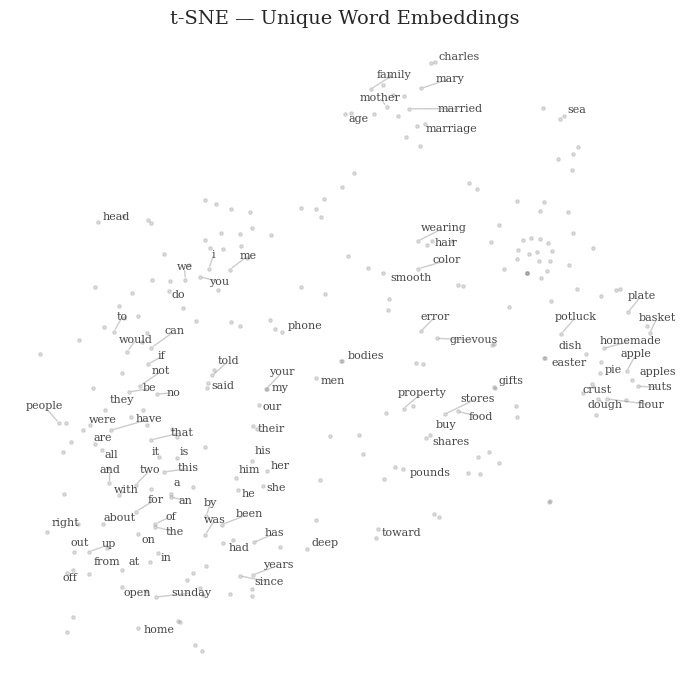

In [35]:
# tSNE and visualization

from adjustText import adjust_text
from collections import defaultdict
from sklearn.decomposition import PCA
from sklearn.manifold import TSNE

# group embeddings by word
word2vecs = defaultdict(list)
for w, v in zip(words, embeddings):
    w_clean = w.strip()
    if w_clean:
        word2vecs[w_clean].append(v)

# average pooling to get one embedding per unique word
unique_words = []
unique_embs = []

for w, vecs in word2vecs.items():
    unique_words.append(w)
    unique_embs.append(np.mean(vecs, axis=0))

unique_embs = np.array(unique_embs)
print(f"[INFO] unique words = {len(unique_words)}")


# Select top words to label
scores = np.linalg.norm(unique_embs, axis=1)
top_k = 100
top_idx = np.argsort(scores)[-top_k:]
print(f"[INFO] labeling top {top_k} unique words")


# PCA reduce to 50 dims (safer for t-SNE)
pca = PCA(n_components=min(50, unique_embs.shape[1], unique_embs.shape[0]-1))
X50 = pca.fit_transform(unique_embs)

tsne = TSNE(
    n_components=2,
    perplexity=30,
    learning_rate=200,
    max_iter=1000,
    metric="cosine",
    random_state=42,
    verbose=1
)
X2 = tsne.fit_transform(X50)


# Plot + labels
plt.figure(figsize=(7,7))
plt.scatter(X2[:,0], X2[:,1], s=6, alpha=0.25, color="gray")

texts = []
for i in top_idx:
    t = plt.text(
        X2[i,0], X2[i,1],
        unique_words[i],
        fontsize=8,
        alpha=0.85
    )
    texts.append(t)


# auto adjust text to reduce overlaps
adjust_text(
    texts,
    arrowprops=dict(
        arrowstyle="-",
        color="gray",
        alpha=0.4
    ),
    expand_text=(1.1, 1.2),
    force_points=0.15,
    force_text=0.3
)

plt.title("t-SNE — Unique Word Embeddings", fontsize=14)
plt.axis("off")
plt.tight_layout()
plt.savefig("glove_tsne_unique.pdf", bbox_inches="tight")
plt.show()

In [59]:
# plot PCA of embeddings for one story
import matplotlib.pyplot as plt
from sklearn.decomposition import PCA   
story_name = list(story_embeddings.keys())[0]
emb = story_embeddings[story_name]
pca = PCA(n_components=2)
emb_2d = pca.fit_transform(emb)
plt.scatter(emb_2d[:, 0], emb_2d[:, 1])
plt.title(f"PCA of embeddings for story: {story_name}")
plt.xlabel("PC1")
plt.ylabel("PC2")
plt.show()

TypeError: float() argument must be a string or a real number, not 'dict'

/opt/miniconda3/envs/215a/lib/python3.13/site-packages/sklearn/utils/extmath.py:350: RuntimeWarning: divide by zero encountered in matmul
  Q, _ = normalizer(A @ Q)
/opt/miniconda3/envs/215a/lib/python3.13/site-packages/sklearn/utils/extmath.py:350: RuntimeWarning: overflow encountered in matmul
  Q, _ = normalizer(A @ Q)
/opt/miniconda3/envs/215a/lib/python3.13/site-packages/sklearn/utils/extmath.py:350: RuntimeWarning: invalid value encountered in matmul
  Q, _ = normalizer(A @ Q)
/opt/miniconda3/envs/215a/lib/python3.13/site-packages/sklearn/utils/extmath.py:351: RuntimeWarning: divide by zero encountered in matmul
  Q, _ = normalizer(A.T @ Q)
/opt/miniconda3/envs/215a/lib/python3.13/site-packages/sklearn/utils/extmath.py:351: RuntimeWarning: overflow encountered in matmul
  Q, _ = normalizer(A.T @ Q)
/opt/miniconda3/envs/215a/lib/python3.13/site-packages/sklearn/utils/extmath.py:351: RuntimeWarning: invalid value encountered in matmul
  Q, _ = normalizer(A.T @ Q)
/opt/miniconda3/en

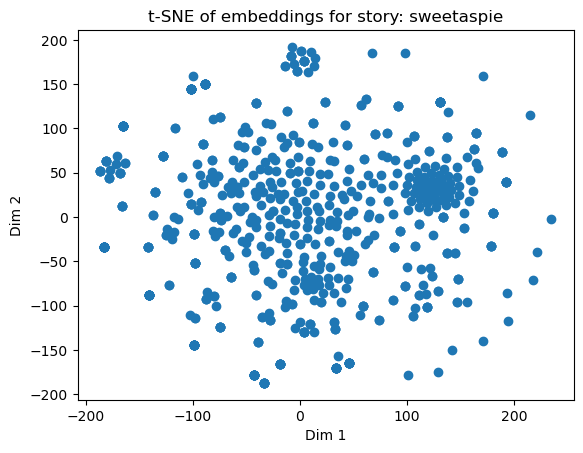

In [ ]:
# plot t sne of embeddings for one story
from sklearn.manifold import TSNE
tsne = TSNE(n_components=2, random_state=215)
emb_tsne = tsne.fit_transform(emb)
plt.scatter(emb_tsne[:, 0], emb_tsne[:, 1])
plt.title(f"t-SNE of embeddings for story: {story_name}")
plt.xlabel("Dim 1")
plt.ylabel("Dim 2")
plt.show()

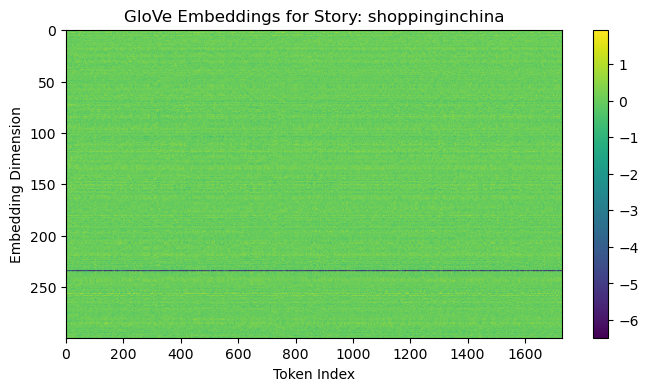

In [ ]:
# plot the embedding of the first story
import matplotlib.pyplot as plt

story_name = list(story_embeddings.keys())[7]
story_emb = story_embeddings[story_name]

plt.figure(figsize=(8, 4))
plt.imshow(story_emb.T, aspect='auto', cmap='viridis')
plt.colorbar()
plt.title(f"GloVe Embeddings for Story: {story_name}")
plt.xlabel("Token Index")
plt.ylabel("Embedding Dimension")
plt.show()

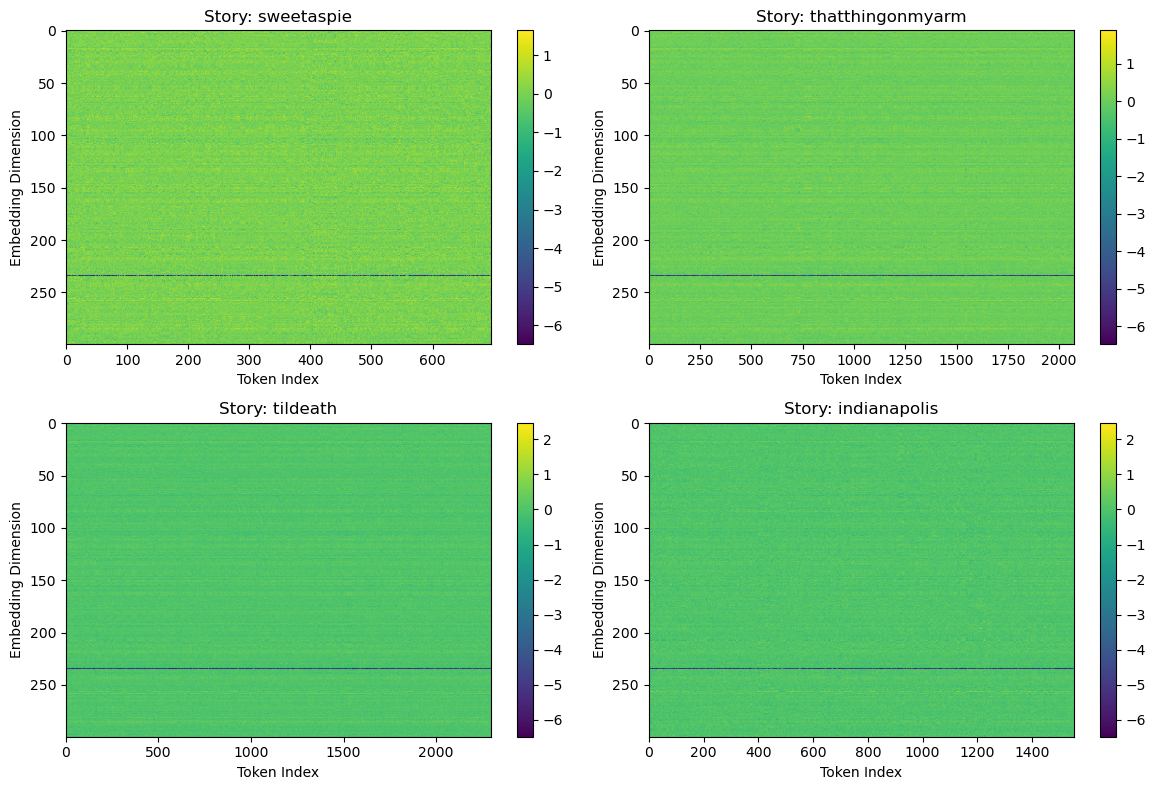

In [ ]:
#plot 4 embeddings in a subplot
plt.figure(figsize=(12, 8))
for i, story_name in enumerate(list(story_embeddings.keys())[:4]):
    story_emb = story_embeddings[story_name]
    plt.subplot(2, 2, i+1)
    plt.imshow(story_emb.T, aspect='auto', cmap='viridis')
    plt.colorbar()
    plt.title(f"Story: {story_name}")
    plt.xlabel("Token Index")
    plt.ylabel("Embedding Dimension")
plt.tight_layout()
plt.show()